In [2]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

In [3]:
train_dir=r'D:\WorkOut\Research\Tomato Disease Detection\tomato\Dataset\PlantVillage'
valid_dir=r'D:\WorkOut\Research\Tomato Disease Detection\tomato\Dataset\val'
for d in [train_dir, valid_dir]:
    filepaths = []
    labels=[] 
    classlist=sorted(os.listdir(d))
    for klass in classlist:
        label=klass.split('__')[1]
        classpath=os.path.join(d, klass)
        flist=sorted(os.listdir(classpath))
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)            
            labels.append(label)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')        
    if d == train_dir:
        df=pd.concat([Fseries, Lseries], axis=1)
    else:
        valid_df=pd.concat([Fseries, Lseries], axis=1)
train_df, test_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=df['labels'])   
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

train_df lenght:  14410   test_df length:  1602   valid_df length:  1000
The number of classes in the dataset is:  10
            CLASS               IMAGE COUNT 
       _Bacterial_spot             1914     
        _Early_blight               900     
         _Late_blight              1718     
          _Leaf_Mold                857     
     _Septoria_leaf_spot           1594     
_Spider_mites Two-spotted_spider_mite     1508     
         _Target_Spot              1263     
_Tomato_Yellow_Leaf_Curl_Virus     2888     
     _Tomato_mosaic_virus           336     
           _healthy                1432     
_Tomato_Yellow_Leaf_Curl_Virus  has the most images=  2888   _Tomato_mosaic_virus  has the least images=  336
average height=  256  average width=  256 aspect ratio=  1.0


In [4]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

#trim
max_samples=50
min_samples=30
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  50  and the minimum samples in any class is  30


In [5]:
working_dir=r'./'
img_size=(256,256)
batch_size=30
trgen=ImageDataGenerator(horizontal_flip=True)

t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='')

train_gen=trgen.flow_from_dataframe(train_df,
                                    x_col='filepaths',
                                    y_col='labels',
                                    target_size=img_size,
                                    class_mode='categorical',
                                    color_mode='rgb',
                                    shuffle=True,
                                    batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='')

valid_gen=t_and_v_gen.flow_from_dataframe(valid_df,
                                          x_col='filepaths',
                                          y_col='labels',
                                          target_size=img_size,
                                          class_mode='categorical',
                                          color_mode='rgb',
                                          shuffle=False,
                                          batch_size=batch_size)

length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='')

test_gen=t_and_v_gen.flow_from_dataframe(test_df,
                                         x_col='filepaths',
                                         y_col='labels',
                                         target_size=img_size,
                                         class_mode='categorical',
                                         color_mode='rgb',
                                         shuffle=False,
                                         batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 500 validated image filenames belonging to 10 classes.           for train generator 
Found 1000 validated image filenames belonging to 10 classes.          for valid generator 
Found 1602 validated image filenames belonging to 10 classes.          for test generator 
test batch size:  18   test steps:  89  number of classes :  10


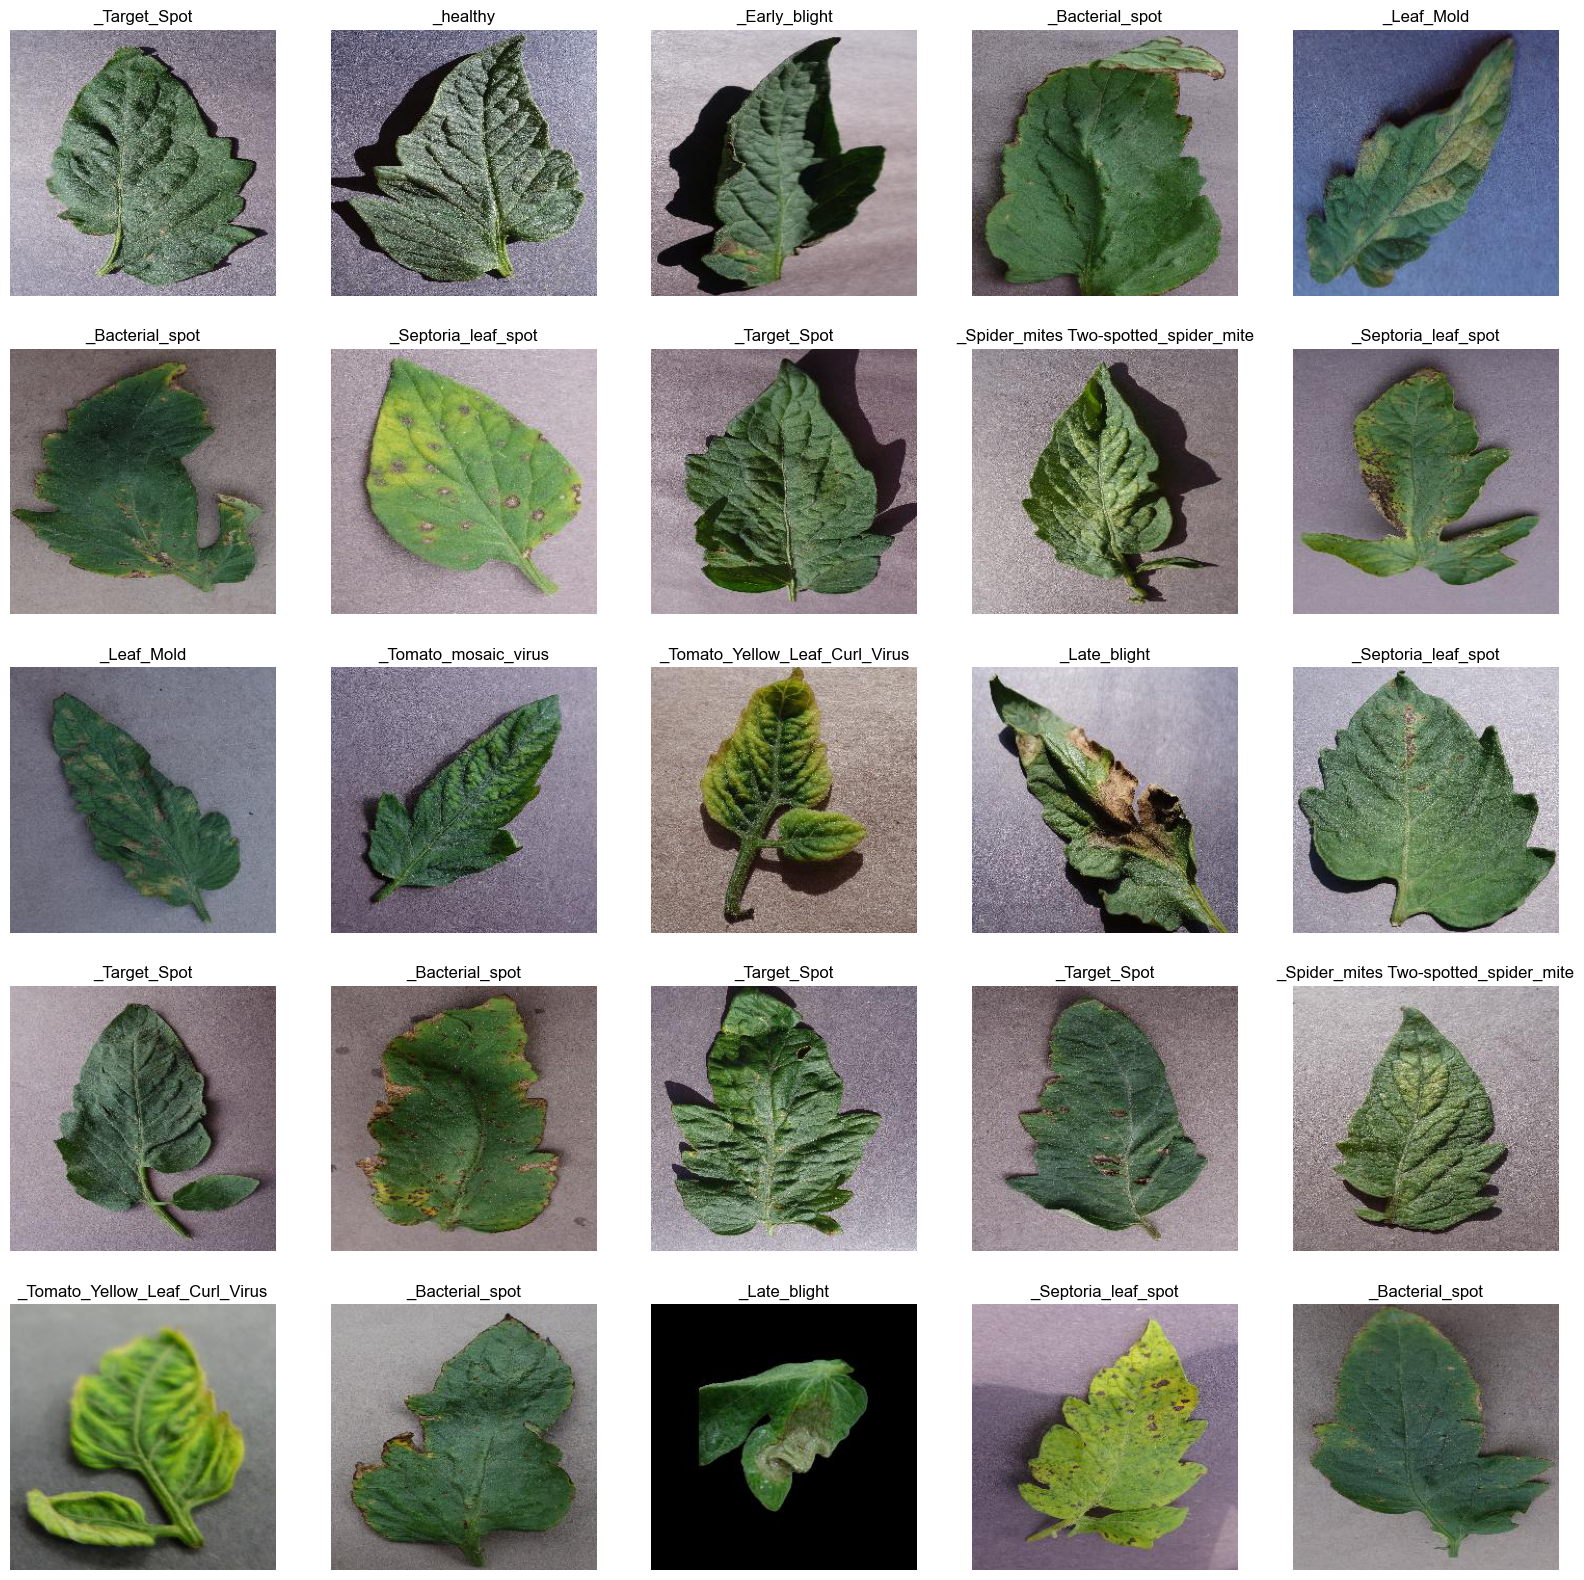

In [6]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='black', fontsize=12)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

In [55]:
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 

base_model.trainable=True
x=base_model.output

x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.8),activity_regularizer=regularizers.l1(0.07),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)

lr=.001
model.summary()
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling_24 (Rescaling)    (None, 256, 256, 3)          0         ['input_13[0][0]']            
                                                                                                  
 normalization_12 (Normaliz  (None, 256, 256, 3)          7         ['rescaling_24[0][0]']        
 ation)                                                                                           
                                                                                                  
 rescaling_25 (Rescaling)    (None, 256, 256, 3)          0         ['normalization_12[0][0

                                                                                                  
 block2a_expand_conv (Conv2  (None, 128, 128, 144)        3456      ['block1b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block2a_expand_bn (BatchNo  (None, 128, 128, 144)        576       ['block2a_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block2a_expand_activation   (None, 128, 128, 144)        0         ['block2a_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block2a_d

 block2c_expand_conv (Conv2  (None, 64, 64, 192)          6144      ['block2b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block2c_expand_bn (BatchNo  (None, 64, 64, 192)          768       ['block2c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block2c_expand_activation   (None, 64, 64, 192)          0         ['block2c_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block2c_dwconv (DepthwiseC  (None, 64, 64, 192)          1728      ['block2c_expand_activation[0]
 onv2D)   

 D)                                                                                               
                                                                                                  
 block3b_expand_bn (BatchNo  (None, 32, 32, 288)          1152      ['block3b_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block3b_expand_activation   (None, 32, 32, 288)          0         ['block3b_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block3b_dwconv (DepthwiseC  (None, 32, 32, 288)          7200      ['block3b_expand_activation[0]
 onv2D)                                                             [0]']                         
          

 block4a_expand_conv (Conv2  (None, 32, 32, 288)          13824     ['block3c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block4a_expand_bn (BatchNo  (None, 32, 32, 288)          1152      ['block4a_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block4a_expand_activation   (None, 32, 32, 288)          0         ['block4a_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block4a_dwconv_pad (ZeroPa  (None, 33, 33, 288)          0         ['block4a_expand_activation[0]
 dding2D) 

 D)                                                                                               
                                                                                                  
 block4c_expand_bn (BatchNo  (None, 16, 16, 576)          2304      ['block4c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block4c_expand_activation   (None, 16, 16, 576)          0         ['block4c_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block4c_dwconv (DepthwiseC  (None, 16, 16, 576)          5184      ['block4c_expand_activation[0]
 onv2D)                                                             [0]']                         
          

 block4e_expand_conv (Conv2  (None, 16, 16, 576)          55296     ['block4d_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block4e_expand_bn (BatchNo  (None, 16, 16, 576)          2304      ['block4e_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block4e_expand_activation   (None, 16, 16, 576)          0         ['block4e_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block4e_dwconv (DepthwiseC  (None, 16, 16, 576)          5184      ['block4e_expand_activation[0]
 onv2D)   

 rmalization)                                                                                     
                                                                                                  
 block5b_expand_activation   (None, 16, 16, 816)          0         ['block5b_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block5b_dwconv (DepthwiseC  (None, 16, 16, 816)          20400     ['block5b_expand_activation[0]
 onv2D)                                                             [0]']                         
                                                                                                  
 block5b_bn (BatchNormaliza  (None, 16, 16, 816)          3264      ['block5b_dwconv[0][0]']      
 tion)                                                                                            
          

 block5d_expand_bn (BatchNo  (None, 16, 16, 816)          3264      ['block5d_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block5d_expand_activation   (None, 16, 16, 816)          0         ['block5d_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block5d_dwconv (DepthwiseC  (None, 16, 16, 816)          20400     ['block5d_expand_activation[0]
 onv2D)                                                             [0]']                         
                                                                                                  
 block5d_bn (BatchNormaliza  (None, 16, 16, 816)          3264      ['block5d_dwconv[0][0]']      
 tion)    

                                                                                                  
 block6a_expand_bn (BatchNo  (None, 16, 16, 816)          3264      ['block6a_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6a_expand_activation   (None, 16, 16, 816)          0         ['block6a_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block6a_dwconv_pad (ZeroPa  (None, 19, 19, 816)          0         ['block6a_expand_activation[0]
 dding2D)                                                           [0]']                         
                                                                                                  
 block6a_d

 block6c_expand_bn (BatchNo  (None, 8, 8, 1392)           5568      ['block6c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6c_expand_activation   (None, 8, 8, 1392)           0         ['block6c_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block6c_dwconv (DepthwiseC  (None, 8, 8, 1392)           34800     ['block6c_expand_activation[0]
 onv2D)                                                             [0]']                         
                                                                                                  
 block6c_bn (BatchNormaliza  (None, 8, 8, 1392)           5568      ['block6c_dwconv[0][0]']      
 tion)    

                                                                                                  
 block6e_expand_bn (BatchNo  (None, 8, 8, 1392)           5568      ['block6e_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6e_expand_activation   (None, 8, 8, 1392)           0         ['block6e_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block6e_dwconv (DepthwiseC  (None, 8, 8, 1392)           34800     ['block6e_expand_activation[0]
 onv2D)                                                             [0]']                         
                                                                                                  
 block6e_b

 D)                                                                                               
                                                                                                  
 block7a_expand_bn (BatchNo  (None, 8, 8, 1392)           5568      ['block7a_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block7a_expand_activation   (None, 8, 8, 1392)           0         ['block7a_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block7a_dwconv (DepthwiseC  (None, 8, 8, 1392)           12528     ['block7a_expand_activation[0]
 onv2D)                                                             [0]']                         
          

 top_activation (Activation  (None, 8, 8, 1536)           0         ['top_bn[0][0]']              
 )                                                                                                
                                                                                                  
 max_pool (GlobalMaxPooling  (None, 1536)                 0         ['top_activation[0][0]']      
 2D)                                                                                              
                                                                                                  
 dense_24 (Dense)            (None, 256)                  393472    ['max_pool[0][0]']            
                                                                                                  
 dropout_12 (Dropout)        (None, 256)                  0         ['dense_24[0][0]']            
                                                                                                  
 dense_25 

In [56]:
class ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch):
        super(ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True
        
    def on_train_begin(self, logs=None):
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: 
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False 
        if self.epochs == 1:
            self.ask=False
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter S to stop training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() 
        
    def on_train_end(self, logs=None):    
        tr_duration=time.time() - self.start_time           
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) 
        
    def on_epoch_end(self, epoch, logs=None):  
        if self.ask: 
            if epoch + 1 ==self.ask_epoch: 
                print('\n Enter S to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'S' or ans =='s' or ans == '0':
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True 
                else: 
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)

In [57]:
epochs=30
ask_epoch=30
ask=ASK(model, epochs,  ask_epoch)
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1,restore_best_weights=True)
callbacks=[rlronp, estop, ask]

In [58]:
history=model.fit(x=train_gen,
                  epochs=epochs,
                  verbose=1,
                  callbacks=callbacks,
                  validation_data=valid_gen,
                  validation_steps=None,
                  shuffle=False,
                  initial_epoch=0)

ask_epoch >= epochs, will train for  30  epochs
Training will proceed until epoch 30  then you will be asked to
 enter S to stop training or enter an integer for how many more epochs to run then be asked again
Epoch 1/30
17/17 [==============================] - 129s 6s/step - loss: 298.0899 - accuracy: 0.1160 - val_loss: 230.6789 - val_accuracy: 0.1310 - lr: 0.0010
Epoch 2/30
17/17 [==============================] - 104s 6s/step - loss: 189.8759 - accuracy: 0.1800 - val_loss: 152.4308 - val_accuracy: 0.1490 - lr: 0.0010
Epoch 3/30
17/17 [==============================] - 103s 6s/step - loss: 126.9160 - accuracy: 0.2320 - val_loss: 104.7402 - val_accuracy: 0.1680 - lr: 0.0010
Epoch 4/30
17/17 [==============================] - 104s 6s/step - loss: 88.8277 - accuracy: 0.2540 - val_loss: 74.9302 - val_accuracy: 0.1610 - lr: 0.0010
Epoch 5/30
17/17 [==============================] - 99s 6s/step - loss: 64.7981 - accuracy: 0.2260 - val_loss: 55.9382 - val_accuracy: 0.1710 - lr: 0.0010
Epoch

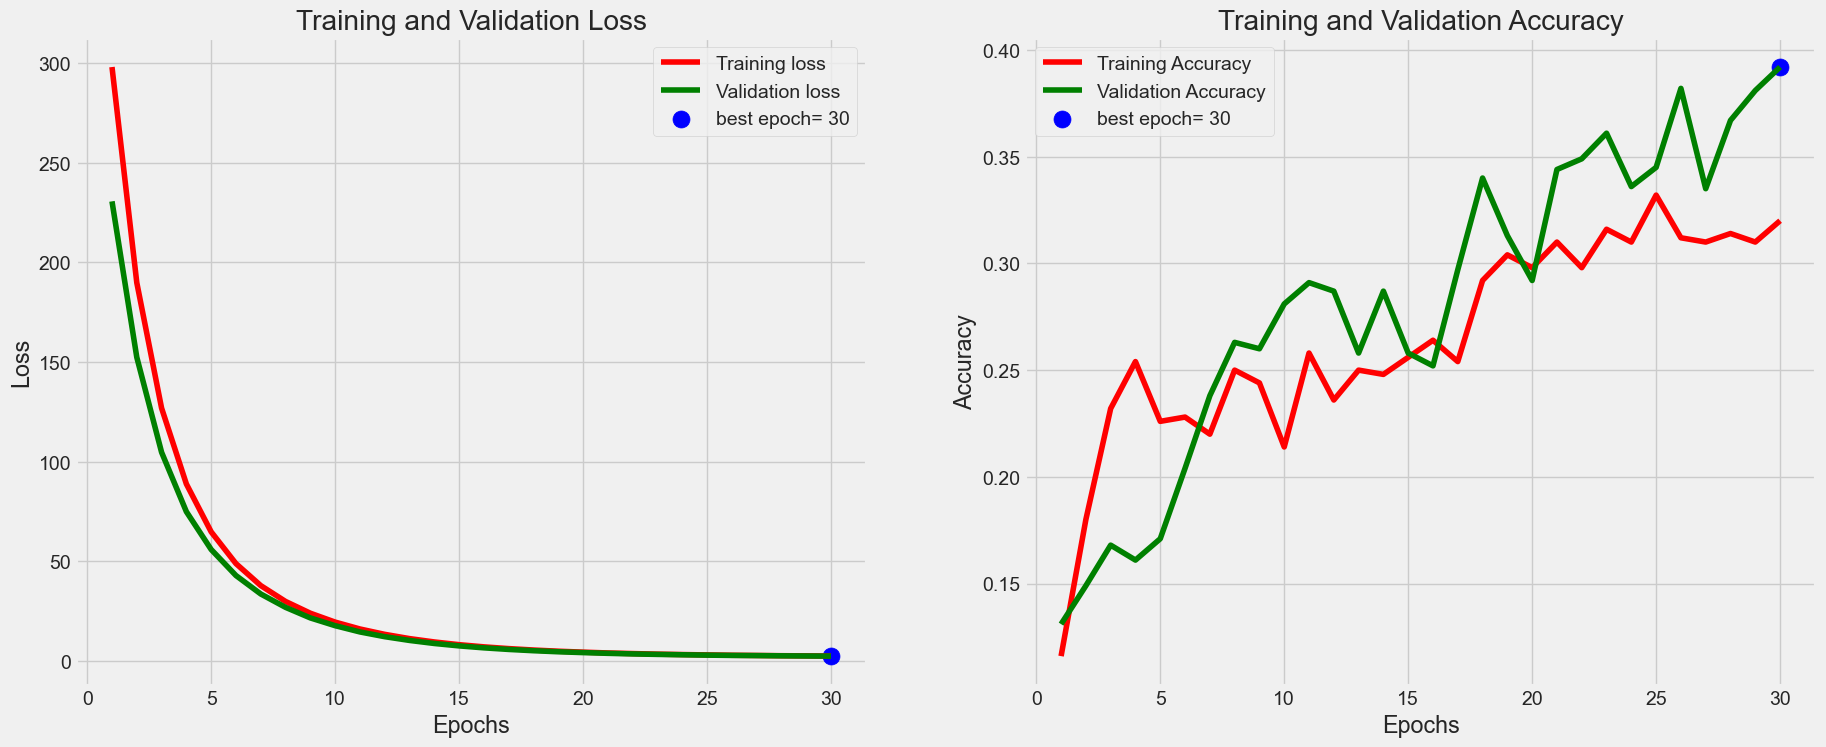

In [60]:
def tr_plot(tr_data, start_epoch):
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)

In [ ]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(train_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, steps=test_steps, verbose=1) 
    tests=len(preds)
    
    for i, p in enumerate(preds):
            pred_index=np.argmax(p)         
            true_index=test_gen.labels[i]  
            if pred_index != true_index:                                           
                errors=errors + 1
            y_pred.append(pred_index)
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4)
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

In [ ]:

def plot_predictions(model, generator, classNames, num_images=15):
    plt.figure(figsize=(15, 15))
    gs = plt.GridSpec(5, 3, height_ratios=[1, 1, 1.2, 1.2, 1.2], wspace=0.1, hspace=0.4)
    i = 0
    while i < num_images:
        images, labels = next(generator)
        images = np.array(images)
        predictions = model.predict(images)
        for j in range(images.shape[0]):
            ax = plt.subplot(gs[i])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.grid(False)
            ax.imshow(images[j] / 255.0)
            predicted_class = classNames[np.argmax(predictions[j])]
            confidence = round(100 * (np.max(predictions[j])), 2)
            actual_class = classNames[np.argmax(labels[j])]
            ax.set_title(f"Actual: {actual_class}, \nPredicted: {predicted_class}\nConfidence: {confidence}%", fontsize=10)
            i += 1
            if i == num_images:
                break
        if i == num_images:
            break
    plt.show()



In [ ]:
plot_predictions(model, test_gen, classlist, num_images=15)
